# LightGBM Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

首先 import 必要的模块

In [10]:
import lightgbm as lgbm

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [11]:
# path to where the data lies
dpath = '../data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [12]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [13]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

第一轮参数调整得到的n_estimators最优值（699），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [14]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [15]:
# prepare cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [16]:
params = {'boosting_type': 'gbdt', 
          'objective': 'multiclass', 
          'nthread': -1, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 80, 
          'max_depth': 5,
          'max_bin': 127, 
          'subsample_for_bin': 50000,
          'subsample': 0.8, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 1, 
          'reg_lambda': 0,
          'min_split_gain': 0.0, 
          'min_child_weight': 1, 
          'min_child_samples': 20, 
          'scale_pos_weight': 1}

lgbm2_1 = lgbm.sklearn.LGBMClassifier(n_estimators=787, seed=0, **params)

gsearch2_1 = GridSearchCV(lgbm2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.best_params_,     gsearch2_1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, -0.4622122995643971)

In [17]:
gsearch2_1.cv_results_

/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packa

{'mean_fit_time': array([137.12614284, 133.8379487 , 124.63552628, 181.31168971,
        180.05300164, 175.28647285, 238.66354671, 233.93950438,
        220.6420989 , 272.86165175, 257.46714797, 216.24198747]),
 'std_fit_time': array([ 0.23470745,  3.74648185,  2.11386762,  2.07062984,  5.37423089,
         4.25860297,  2.72480708,  6.30288768,  2.1772602 ,  9.69978493,
         3.08063131, 17.55636506]),
 'mean_score_time': array([ 8.09085474,  6.327179  ,  5.0467196 , 12.11420579, 10.57515736,
        10.15737762, 20.76160483, 25.04425573, 18.80829663, 38.98694701,
        32.40713978, 19.57049036]),
 'std_score_time': array([ 1.38493258,  1.46495974,  0.61589524,  4.64576691,  3.06439342,
         1.496257  ,  8.82567356,  5.75544968,  5.41203213,  2.60555821,
        10.16931012,  9.20698188]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fals

Best: -0.462212 using {'max_depth': 5, 'min_child_weight': 1}


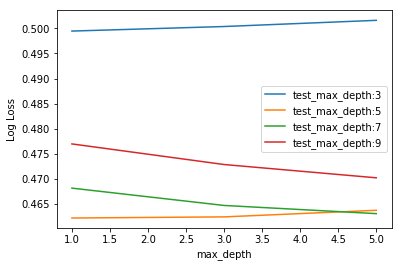

In [18]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )